# Weather Prediction
### Cisco Mtuity Hackathon

In [1]:
import os
import pandas as pd
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression as classifier
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from matplotlib import pyplot

In [2]:
def readDataFromCSV(filename):
    df = pd.read_csv(filename)
    df = df.drop('windchill', 1)

    def filterMonth(row):
        try:
            return int(str(row['date']).split('-')[0][1])
        except:
            return 0

    df['month'] = df.apply(filterMonth, axis=1)

    def convertTime(row):
        try:
            times = str(row['datetime']).split('T')[1].split(':')
            return float(times[0]) + float(times[1]) / 60
        except:
            pass

    df['time'] = df.apply(convertTime, axis=1)

    def convertDayOfYear(row):
        try:
            date = datetime.datetime.strptime(row['datetime'], '%Y-%m-%dT%H:%M:%SZ').strftime('%j')
            return float(date)
        except:
            pass

    df['date'] = df.apply(convertDayOfYear, axis=1)

    df = df.fillna(0)

    def winddirToNum(row):
        try:
            winddir = -1
            if 'n' in row['winddir']:
                winddir = 0
                if 'w' in row['winddir']:
                    winddir = 315
                elif 'e' in row['winddir']:
                    winddir = 45
            elif 's' in row['winddir']:
                winddir = 180
                if 'w' in row['winddir']:
                    winddir += 45
                elif 'e' in row['winddir']:
                    winddir -= 45
            elif 'w' in row['winddir']:
                winddir ^= WEST
            elif 'e' in row['winddir']:
                winddir ^= EAST
            if winddir >= 0:
                return winddir
            elif row['winddir'] == 'calm' or row['winddir'] == 'variable':
                return 0
            else:
                return int(row['winddir'])
        except:
            pass

    df['winddir'] = df.apply(winddirToNum, axis=1)
    df = df.fillna(0)
    temp_df = pd.DataFrame(
        {'conditions': df.conditions.unique(), 'condition_id': range(len(df.conditions.unique()))})
    df = df.merge(temp_df, on='conditions', how='left')
    df = df.drop('conditions', 1).drop('precip', 1)

    def filterEvents(row):
        try:
            float(str(row['events']))
            return 0
        except:
            return row['events']

    def filterDewpoints(row):
        try:
            float(str(row['dewpoint']))
            return row['dewpoint']
        except:
            return 0

    def filterheatindex(row):
        try:
            float(row['heatindex'])
            return row['heatindex']
        except:
            return 0
    
    def filtergustspeed(row):
        try:
            float(str(row['gustspeed']))
            return row['gustspeed']
        except:
            return 0
    
    def filterwindspeed(row):
        try:
            float(str(row['windspeed']))
            return row['windspeed']
        except:
            return 0
    
    def filtervisibility(row):
        try:
            float(str(row['visibility']))
            return row['visibility']
        except:
            return 10
        
    def filterpresure(row):
        try:
            float(str(row['presure']))
            return row['presure']
        except:
            return 10
    
    df['events'] = df.apply(filterEvents, axis=1)
    df['dewpoint'] = df.apply(filterDewpoints, axis=1)
    df['heatindex'] = df.apply(filterheatindex, axis=1)
#     df['gustspeed'] = df.apply(filtergustspeed, axis=1)
#     df['windspeed'] = df.apply(filtergustspeed, axis=1)
#     df['visibility'] = df.apply(filtervisibility, axis=1)
#     df['presure'] = df.apply(filterpresure, axis=1)
    temp_df = pd.DataFrame({'events': df.events.unique(), 'events_id': range(len(df.events.unique()))})
    df = df.merge(temp_df, on='events', how='left')
    df = df.drop('events', 1)
    return df

In [3]:
def getData(filename, target):
    df = readDataFromCSV(filename)
    timestamps = df['datetime']
    features = df.drop('datetime', 1).drop(target, 1)
    labels = df[target]
#     print features.head()
    features = np.array(features, dtype=float)
    labels = np.array(labels, dtype=float)
    return timestamps, features, labels,df

In [4]:
def getFileNames(city_id):
    train_sets = sorted(os.listdir("Training Data"))
    test_sets = sorted(os.listdir("Test Data"))
    print train_sets
    print test_sets
    return "Training Data/"+train_sets[city_id], "Test Data/"+test_sets[city_id]

train_file, test_file = getFileNames(1)

['Barcelona_Spain_Jan1st2006_April06th2017_train.csv', 'EastCleveland_Ohio_Jan1st2006_April06th2017_train.csv', 'Lancaster_California_Jan1st2006_April06th2017_train.csv', 'Nagasaki_Japan_Jan01st2006_April06th2017_Train.csv', 'Seoul_SouthKorea_Jan01st2006_April06thth2017_train.csv']
['Barcelona_SpainTest.csv', 'EastCleveland_Ohio_test.csv', 'Lancaster_California_test.csv', 'Nagasaki_Japan_test.csv', 'Seoul_SouthKorea_test.csv']


In [5]:
_, feature_train, label_train, train_df = getData(train_file, 'temp')

timestamps, feature_test, label_test, test_df = getData(test_file, 'temp')

In [6]:
clf = classifier()
clf.fit(feature_train, label_train)
pred = clf.predict(feature_test)
print "RMSE for Linear Regression:", mean_squared_error(label_test, pred)

RMSE for Linear Regression: 4.95403035086


In [7]:
result = pd.DataFrame({"ids": timestamps, "pred": pred, "truedata": label_test})
result.to_csv("result.csv")

In [8]:
T_train_xgb = xgb.DMatrix(feature_train, label_train)
T_test_xgb = xgb.DMatrix(feature_test)
params = {"objective": "reg:linear", "booster": "gblinear"}
gbm = xgb.train(dtrain=T_train_xgb, params=params)
Y_pred = gbm.predict(data=T_test_xgb)
print "R^2:", clf.score(feature_test, label_test)
print "RMSE for XGBoost", mean_squared_error(label_test, Y_pred)

R^2: 0.943366553343
RMSE for XGBoost 27.1625718397


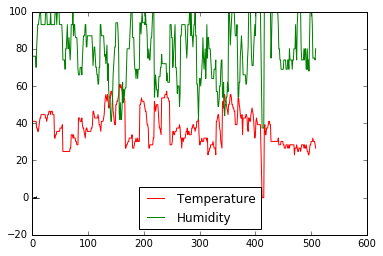

In [9]:
pyplot.bar(range(len(clf.coef_)), clf.coef_)
plot_df = train_df[train_df['humidity'] > 10]
l1, = pyplot.plot(plot_df['temp'][:500], 'red', label='Temperature')
l2, = pyplot.plot(plot_df['humidity'][:500], 'green', label='Humidity')
pyplot.legend(handles=[l1, l2],loc="best")
pyplot.savefig('Temp and Humidity.jpg')
pyplot.show()

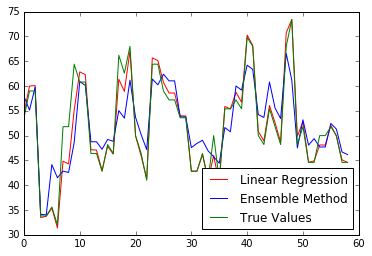

In [11]:
l1, = pyplot.plot(pred, 'red', label='Linear Regression')
l2, = pyplot.plot(Y_pred, 'blue', label='Ensemble Method')
l3, = pyplot.plot(label_test, 'green', label='True Values')
pyplot.legend(handles=[l1, l2, l3],loc="best")
pyplot.savefig('Results0.jpg')
pyplot.show()